In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import re
from glob import iglob as glob
from os.path import basename

from collections import Counter
import matplotlib.pyplot as plt
import numpy as np 

from funcy import *
import seaborn as sns
import itertools
import operator
from scipy.stats import chi2_contingency

In [3]:
xkcd_colors = sns.xkcd_palette(["grass green", "blue", "light red", "cerulean",
                                "red", "sky blue", "teal", "orange", "light green",
                                "magenta", "yellow", "light blue", "grey", "cobalt",
                                "grass", "algae green", "coral", "cerise", "steel",
                                "hot purple", "mango", "pale lime", "sand", "rouge"])
colors = itertools.cycle(xkcd_colors)

# Text analysis of transcripts

This notebook presents a first exploratory analysis of the transcriptions for the CDC project. There are 8 transcripts, received as doc files (converted to txt using textutil).

### Load and preprocess

In [4]:
transcript_dir = "../data/transcripts/*.txt"

docs = {}
for f in glob(transcript_dir):
    with open(f) as inpt:
        docs[basename(f)] = select(lambda y: len(y) > 0, walk(lambda x: x.strip(), inpt.readlines()))
docs['ESE343-2 GTKY-FB.txt'][0:10];

Check that all files end with "[End" tag. If so, drop text after that.

In [5]:
for k, v in docs.items():
    matches = False
    for idx, line in enumerate(v):
        if re.match("\[End", line):
            matches = True
            break
    if not matches:
        print("{} does not have [End tag".format(k))
    else:
        docs[k] = v[0:idx]

In [6]:
docs['ESP656-2 FB.txt'][-3:]

["Interviewer:\tYeah. Okay. Yeah. We can do that. Because what I was getting at is we don't do the CPR classes, if that was what you were interested in. But I could help you get hooked up with something in the community.",
 'Interviewee:\tOkay.',
 "Interviewer:\tI'm going to go ahead and shut this off and give you your gift card here. And have you, I need you to sign that I actually gave it –"]

Split the docs into (speaker, utterance). Clean speaker by removing additional spaces and colons.

In [7]:
docs = walk_values(lambda x: walk(lambda z: (z[0].replace(":","").strip(), z[1].strip()) if len(z) == 2 else z,
                                      walk(lambda y: y.split(":\t"), x)), docs)
docs['ESE343-2 GTKY-FB.txt'][0:10];

Define a function to recover the actors of each session

In [8]:
def getActors(session):
    return set([x[0] for x in session if len(x) == 2])

In [9]:
for k in docs:
    print(k, getActors(docs[k]))

ESP841-2 FB.txt {'Interviewee', 'Interviewer'}
ESP656-2 FB.txt {'Interviewee', 'Interviewer'}
ESE343-2 GTKY-FB.txt {'Luke', 'Chloe', 'Helene', 'Interviewer', 'Shelly', 'Paul', 'Woman'}
ESE395-2 GTKY-FB.txt {'Interviewee', 'Interviewer', 'Male'}
ESP636-2 FB.txt {'Interviewee', 'Interviewer'}
ESE371-2 GTKY-FB.txt {'Chris', 'Interviewer', 'Misty'}
ESP470-2 FB-audio only.txt {'Interviewee', 'Interviewer', 'Child', 'Gina'}
ESP654-2 FB.txt {'Interviewee', 'Interviewer', 'Interviewee 2'}


### Speaker participation
For each actor in a session, we count the number of times he or she participated during the session.

In [10]:
def getParticipation(session):
    return Counter(map(lambda z: z[0], filter(lambda y: isinstance(y, tuple), session)))

for k, v in docs.items():
    print(k, getParticipation(v))

ESP841-2 FB.txt Counter({'Interviewer': 293, 'Interviewee': 292})
ESP656-2 FB.txt Counter({'Interviewer': 365, 'Interviewee': 364})
ESE343-2 GTKY-FB.txt Counter({'Interviewer': 169, 'Paul': 132, 'Shelly': 84, 'Helene': 46, 'Luke': 25, 'Chloe': 11, 'Woman': 1})
ESE395-2 GTKY-FB.txt Counter({'Interviewer': 95, 'Interviewee': 90, 'Male': 45})
ESP636-2 FB.txt Counter({'Interviewee': 246, 'Interviewer': 244})
ESE371-2 GTKY-FB.txt Counter({'Interviewer': 118, 'Misty': 103, 'Chris': 56})
ESP470-2 FB-audio only.txt Counter({'Interviewer': 359, 'Interviewee': 354, 'Gina': 3, 'Child': 3})
ESP654-2 FB.txt Counter({'Interviewer': 184, 'Interviewee': 178, 'Interviewee 2': 5})


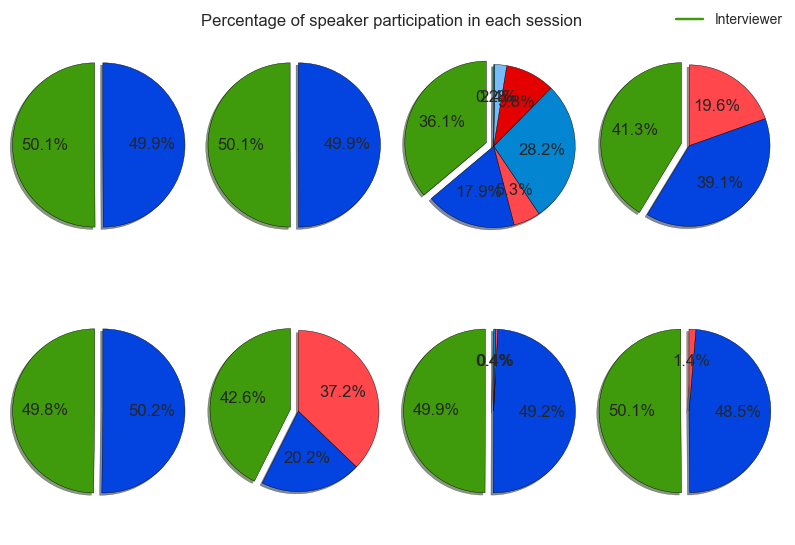

In [11]:
fig, axarr = plt.subplots(2, 4)
for idx, (k, v) in enumerate(docs.items()):
    labels, sizes = zip(*getParticipation(v).items())
    
    sizes = [sizes[labels.index("Interviewer")]] + [s for s, l in zip(sizes, labels) if l != "Interviewer"]
    labels = ["Interviewer"] + ["" for x in labels if x != "Interviewer"]
    
    explode = [0]*len(labels)
    explode[0] = .1
    
    axarr[np.unravel_index(idx, (2, 4))].pie(sizes,
                                             explode = explode,
#                                            labels = labels,
                                             autopct="%1.1f%%",
                                             shadow = True,
                                             startangle = 90,
                                             colors = xkcd_colors)
    
    axarr[np.unravel_index(idx, (2, 4))].axis('equal')
    
#
l = axarr[np.unravel_index(idx, (2, 4))].plot([0], [0], '-', color = xkcd_colors[0], label = "Interviewer")

fig.legend(l, ["Interviewer"], loc = "upper right")
fig.tight_layout()
plt.suptitle("Percentage of speaker participation in each session")
plt.show()

## Error analysis
How many of the utterances contain additional tags, which might be due to errors in the audio file?

In [12]:
errors = walk_values(lambda z: select(lambda y: re.search('\[.*\]', y),
                                                walk(lambda x: x[1] if isinstance(x, tuple) 
                                                          else x[0] if isinstance(x, list)
                                                          else x, z)), docs)
errors['ESE343-2 GTKY-FB.txt'][0:10];

Replace time marks with a standard tag, and drop all text no concerning the error.

In [13]:
for doc, errlist in errors.items():
    newerr = []
    for e in errlist:
        if re.match("\[\d+:\d+:\d+\]", e):
            newerr.append("[Time Mark]")
        else:
            for _ in re.findall("\[.*?\]", e):
                newerr.append(_)
            for _ in re.findall("_____", e):
                newerr.append("[???]")
                
    errors[doc] = newerr


It appears that most of the files contain more or less the same amount of time marks. It is also obvious that __the annotators did not agree in how to annotate the bracketed comments__, so we end up with over 49 different tags. __Even worse, one annotator appears to use underscores instead of brackets__. Furthermore, some of the tags appear to dominate the transcriptions.

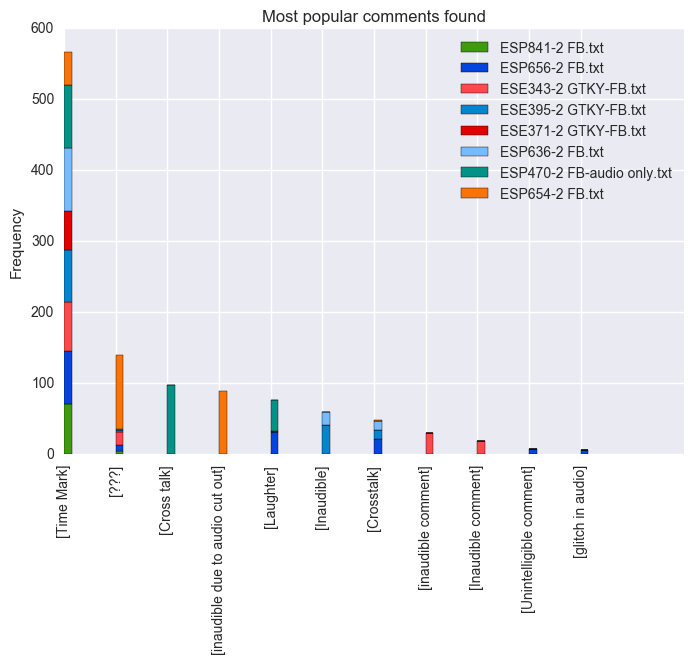

In [14]:
filtered_labels = select_values(lambda v: v > 5, dict(sum([Counter(d) for d in errors.values()])))
filtered_labels = walk(lambda x: x[0], sorted(filtered_labels.items(), key = operator.itemgetter(1), reverse = True))

fig, ax = plt.subplots()
width = 0.15
bottom = np.array([0]*len(filtered_labels))

for idx, (k, d) in enumerate(errors.items()):
    mykeys = Counter(d)
    y = np.array([mykeys[label] for label in filtered_labels])
    x = np.arange(len(filtered_labels))
    ax.bar(x, y, width, bottom=bottom, color = xkcd_colors[idx], label = k)
    bottom += y
    
plt.xticks(np.arange(len(filtered_labels)), filtered_labels, rotation = 'vertical')
ax.set_title("Most popular comments found")
ax.set_ylabel("Frequency")
plt.legend()
plt.show()

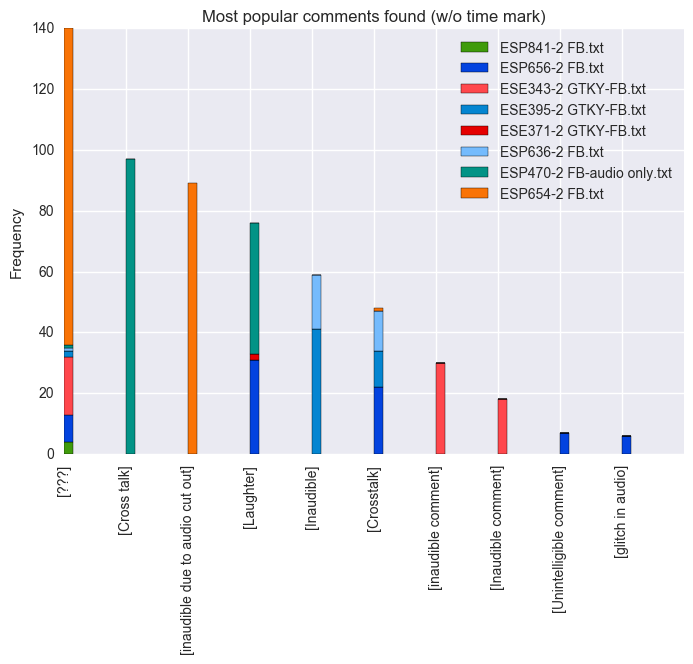

In [15]:
filtered_labels = select_values(lambda v: v > 5, dict(sum([Counter(d) for d in errors.values()])))
filtered_labels = walk(lambda x: x[0], sorted(filtered_labels.items(), key = operator.itemgetter(1), reverse = True))
filtered_labels.remove("[Time Mark]")

fig, ax = plt.subplots()
width = 0.15
bottom = np.array([0]*len(filtered_labels))

for idx, (k, d) in enumerate(errors.items()):
    mykeys = Counter(d)
    y = np.array([mykeys[label] for label in filtered_labels])
    x = np.arange(len(filtered_labels))
    ax.bar(x, y, width, bottom=bottom, color = xkcd_colors[idx], label = k)
    bottom += y
    
plt.xticks(np.arange(len(filtered_labels)), filtered_labels, rotation = 'vertical')
ax.set_title("Most popular comments found (w/o time mark)")
ax.set_ylabel("Frequency")
plt.legend()
plt.show()

How many interactions contain one or more errors?

In [16]:
res = {}
for k, d in docs.items():
    res[k] = []
    
    for line in d:
        
        if isinstance(line, tuple):
            line = line[1]
        elif isinstance(line, list):
            line = line[0]

        if line != "[Time Mark]" and re.search("\[.*\]", line):
            res[k].append(0)
        else:
            res[k].append(1)
    res[k] = Counter(res[k])
print(res)

{'ESP841-2 FB.txt': Counter({1: 629, 0: 72}), 'ESP656-2 FB.txt': Counter({1: 737, 0: 146}), 'ESE343-2 GTKY-FB.txt': Counter({1: 500, 0: 118}), 'ESE395-2 GTKY-FB.txt': Counter({1: 317, 0: 140}), 'ESE371-2 GTKY-FB.txt': Counter({1: 314, 0: 61}), 'ESP636-2 FB.txt': Counter({1: 547, 0: 136}), 'ESP470-2 FB-audio only.txt': Counter({1: 663, 0: 217}), 'ESP654-2 FB.txt': Counter({1: 337, 0: 113})}


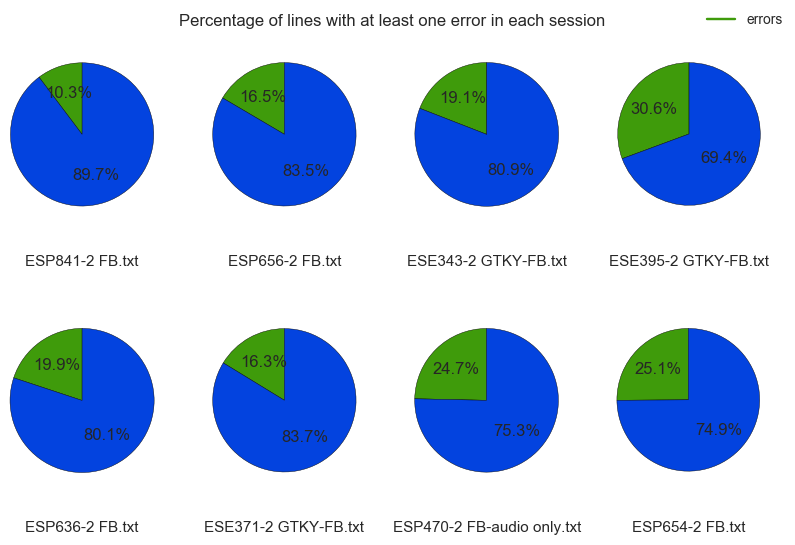

In [17]:
fig, axarr = plt.subplots(2, 4)
for idx, (k, v) in enumerate(docs.items()):
    labels, sizes = zip(*res[k].items())
    
    axarr[np.unravel_index(idx, (2, 4))].pie(sizes,
                                             autopct="%1.1f%%",
                                             shadow = False,
                                             startangle = 90,
                                             colors = xkcd_colors)
    
    axarr[np.unravel_index(idx, (2, 4))].axis('equal')
    axarr[np.unravel_index(idx, (2, 4))].set_xlabel(k)
    
#
l = axarr[np.unravel_index(idx, (2, 4))].plot([0], [0], '-', color = xkcd_colors[0], label = "errors")

fig.legend(l, ["errors"], loc = "upper right")
fig.tight_layout()
plt.suptitle("Percentage of lines with at least one error in each session")
plt.show()

Are there more errors on the side of the interviewer or the side of the interviewee?

In [18]:
res = {}
for k, d in docs.items():
    res[k] = []
    
    for line in d:
        spkr = None
        if isinstance(line, tuple):
            spkr = "Interviewer" if line[0] == "Interviewer" else "Interviewee"
            line = line[1]
        elif isinstance(line, list):
            line = line[0]

        if line != "[Time Mark]" and re.search("\[.*\]", line):
            if spkr:
                res[k].append((spkr, 0))
        else:
            if spkr:
                res[k].append((spkr, 1))
    res[k] = Counter(res[k])
    
t = sum([res[k] for k in res])

print("{:10s}\t0\t1".format(""))
print("--------------------------------------")
print("{:10s}\t{}\t{}".format('Interviewer', t[('Interviewer', 0)], t[('Interviewer', 1)]))
print("{:10s}\t{}\t{}".format('Interviewee', t[('Interviewee', 0)], t[('Interviewee', 1)]))
print()

          	0	1
--------------------------------------
Interviewer	106	1721
Interviewee	181	1857



## Word usage

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(ngram_range=(1,1), stop_words='english', max_features = 50)

In [33]:
for k, d in docs.items():
    # Separate betwee interviewer and interviewee
    interviewer = [line[1] for line in d if isinstance(line, tuple) and line[0] == "Interviewer"]
    X = np.sum(bow.fit_transform(interviewer).toarray(), axis = 0)
    for tag, count in zip(bow.get_feature_names(), X):
        print(tag, count)
    print()

_____ 124
attention 12
children 9
come 11
did 13
different 25
does 16
doesn 10
doing 10
don 10
family 11
feel 12
going 21
good 33
got 13
help 9
job 10
just 30
kids 15
kind 31
know 16
like 67
little 11
ll 9
look 10
looks 11
lot 17
nice 12
oh 12
okay 21
parent 10
parenting 14
pretty 12
really 45
right 28
said 16
say 11
sort 16
sounds 14
talk 9
terms 27
things 18
think 33
time 11
tough 12
ve 10
want 18
way 12
work 10
yeah 55

came 13
come 11
conflict 10
day 15
did 24
didn 30
does 22
doesn 18
doing 12
don 23
family 13
feel 17
getting 11
going 19
good 32
help 23
hmm 54
huh 30
just 34
kind 17
know 44
laughter 22
like 75
little 20
ll 19
look 11
lot 12
mean 16
mm 52
oh 16
okay 140
pretty 23
probably 22
really 22
red 11
relationship 15
right 26
said 16
sister 16
stuff 12
thing 19
things 35
think 39
thought 10
time 22
uh 18
want 15
wanted 10
way 14
yeah 24

_____ 19
able 5
absolutely 4
actually 5
area 5
better 7
bit 8
comment 14
did 6
different 5
doesn 6
doing 15
don 8
draw 5
feel 6
going 6
gonn